In [15]:
import tensorflow as tf
from tensorflow.keras import layers

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

import time
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

### 데이터 로드
* TF에서 제공하는 데이터셋을 load해 간단한 전처리 진행

In [16]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

train_data = train_data / 255.
train_data = train_data.reshape(-1, 28*28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 28*28)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 28*28)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


### 데이터셋 구성
* 학습에 잘 적용할 수 있도록 label 처리
* 데이터셋 구성

In [17]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10 )
  return image, label

In [18]:
batch_size = 32
max_epochs = 100

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### 모델 구성

In [19]:
model = tf.keras.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_shape=(784,)))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=10, activation = 'softmax'))

In [20]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  predictions = model(images[0:1], training=False)
  print("Predictions: ", predictions.numpy())

Predictions:  [[0.1402974  0.18822986 0.05178052 0.1474087  0.05532445 0.05454252
  0.07342594 0.08482766 0.11509528 0.08906772]]


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


### tf.GradientTape 사용을 위한 준비
* 우리가 확인해야할 파라미터들의 출력을 위해 필요한 변수들을 선언해준다.

In [22]:
# use Adam optimizer 
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_object = tf.keras.losses.CategoricalCrossentropy() # 함수를 가져옴
acc_object = tf.keras.metrics.CategoricalAccuracy() # 함수를 가져옴

# record loss and accuracy for every epoch
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

# save loss and accuracy history for plot
loss_history = []
accuracy_history = [(0, 0.0)]

val_loss_history = []
val_accuracy_history = [(0, 0.0)]

In [23]:
def validation(global_step):
  val_acc_object = tf.keras.metrics.CategoricalAccuracy()

  val_mean_loss = tf.keras.metrics.Mean("loss")
  val_mean_accuracy = tf.keras.metrics.Mean("accuracy")

  for images, labels in valid_dataset:
    predictions = model(images, training=False)
    val_loss_value = loss_object(labels, predictions)
    val_acc_value = val_acc_object(labels, predictions)
    
    val_mean_loss(val_loss_value)
    val_mean_accuracy(val_acc_value)
    
  print("valid loss: {:.4g}, valid accuracy: {:.4g}%".format(val_mean_loss.result(),
                                                             val_mean_accuracy.result() * 100))

  val_loss_history.append((global_step.numpy(), val_mean_loss.result().numpy()))
  val_accuracy_history.append((global_step.numpy(), val_mean_accuracy.result().numpy()))


In [24]:
print("start training!")
global_step = tf.Variable(0, trainable=False)
validation(global_step)
num_batches_per_epoch = int(len(train_data) / batch_size)

for epoch in range(max_epochs):
    
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    global_step.assign_add(1)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step.numpy(), mean_loss.result().numpy()))
    
    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration) 
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step.numpy(), loss_value.numpy(), acc_value.numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))
  validation(global_step)
  # clear the history
  mean_accuracy.reset_states()

print("training done!")

epochs: 100.00, step: 168800, loss: 0.0076, accuracy: 96.06% (1289.02 examples/sec; 0.0248 sec/batch)
valid loss: 0.7937, valid accuracy: 87.98%
training done!


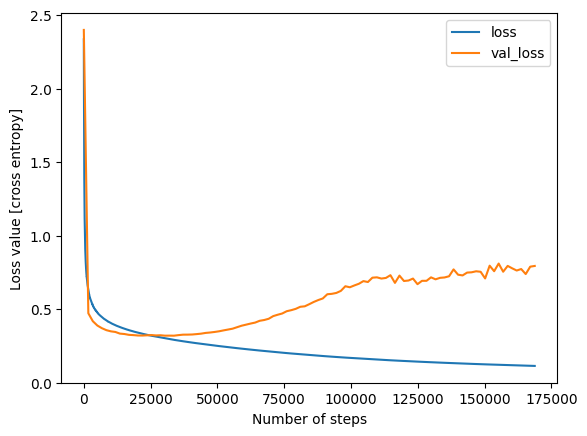

In [25]:
plt.plot(*zip(*loss_history), label='loss')
plt.plot(*zip(*val_loss_history), label='val_loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

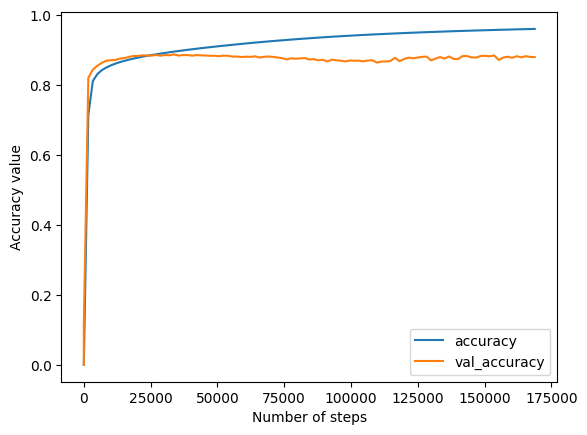

In [26]:
plt.plot(*zip(*accuracy_history), label='accuracy')
plt.plot(*zip(*val_accuracy_history), label='val_accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

In [27]:
acc_object.reset_states()

for images, labels in test_dataset:
  predictions = model(images, training=False)
  acc_object(labels, predictions)
  
print("test accuracy: {:.4g}%".format(acc_object.result() * 100))

test accuracy: 87.35%


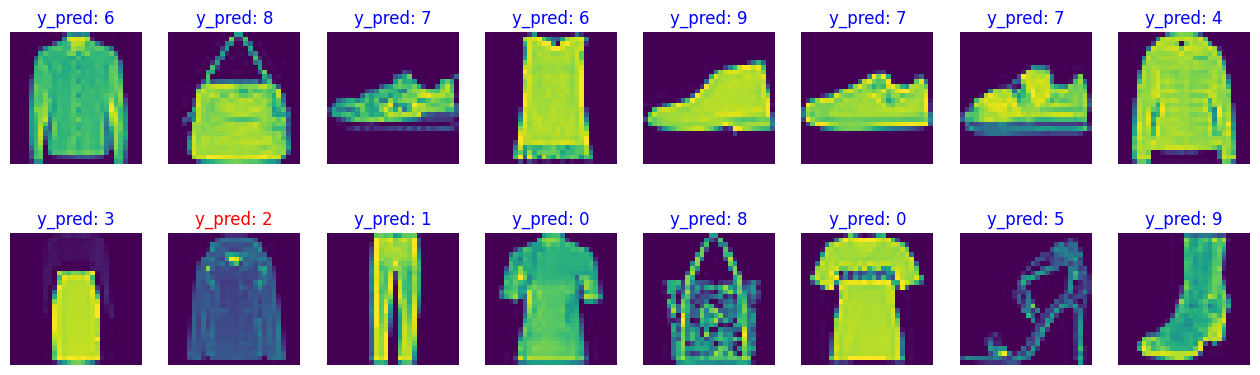

In [28]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')